# Customer Churn Prediction Problem

## Imported Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Load the Dataset and Initial Insights Gathering

In [4]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")

In [5]:
print(df.shape)
print(df.memory_usage(deep=True).sum())
print(df.head())

info_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Unique Values': df.nunique()
})

print(info_df.to_string(index=False))

(7043, 21)
7152287
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies  

In [7]:
churn_counts = df['Churn'].value_counts()
churn_percentages = df['Churn'].value_counts(normalize=True) * 100

print(churn_percentages)

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [8]:
minority_class = churn_counts.min()
majority_class = churn_counts.max()
imbalance_ratio = majority_class / minority_class
print(f"   Class imbalance ratio: {imbalance_ratio:.1f}:1")

   Class imbalance ratio: 2.8:1


In [9]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'customerID' in numerical_cols:
    numerical_cols.remove('customerID')

print(df[numerical_cols].describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

for col in categorical_cols[:]:  # Show first 5 categorical columns
    unique_count = df[col].nunique()
    print(f"   {col}: {unique_count} unique values - {list(df[col].unique())}")

   gender: 2 unique values - ['Female', 'Male']
   Partner: 2 unique values - ['Yes', 'No']
   Dependents: 2 unique values - ['No', 'Yes']
   PhoneService: 2 unique values - ['No', 'Yes']
   MultipleLines: 3 unique values - ['No phone service', 'No', 'Yes']
   InternetService: 3 unique values - ['DSL', 'Fiber optic', 'No']
   OnlineSecurity: 3 unique values - ['No', 'Yes', 'No internet service']
   OnlineBackup: 3 unique values - ['Yes', 'No', 'No internet service']
   DeviceProtection: 3 unique values - ['No', 'Yes', 'No internet service']
   TechSupport: 3 unique values - ['No', 'Yes', 'No internet service']
   StreamingTV: 3 unique values - ['No', 'Yes', 'No internet service']
   StreamingMovies: 3 unique values - ['No', 'Yes', 'No internet service']
   Contract: 3 unique values - ['Month-to-month', 'One year', 'Two year']
   PaperlessBilling: 2 unique values - ['Yes', 'No']
   PaymentMethod: 4 unique values - ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit

## Data Quality Assessment and Little Cleanup

In [13]:
df_cleaned = df.copy()
original_shape = df_cleaned.shape

print(original_shape)

(7043, 21)


In [14]:
duplicate_customers = df_cleaned['customerID'].duplicated().sum()
print(duplicate_customers) ## we don't have any duplicate rows

0


In [17]:
print(df_cleaned['TotalCharges'].dtype)

non_numeric_total = df_cleaned['TotalCharges'].apply(lambda x: not str(x).replace('.', '').replace(' ', '').isdigit())
non_numeric_count = non_numeric_total.sum()
# print(non_numeric_count) -> we had 11 values here

df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

print(df_cleaned['TotalCharges'].dtype) ## converted the total charges column data type from object to float)

object
float64


In [19]:
missing_values = df_cleaned.isnull().sum()
missing_percent = (missing_values / len(df_cleaned) * 100).round(2)

missing_summary = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing %': missing_percent.values
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

print(missing_summary) ## we got the missing summary report for our dataframe.

          Column  Missing Count  Missing %
19  TotalCharges             11       0.16


In [20]:
if len(missing_summary) > 0:  ### we have handled the missing value problem of this dataset
    print("   Missing values found:")
    print(missing_summary.to_string(index=False))

    if 'TotalCharges' in missing_summary['Column'].values:
        total_charges_missing = df_cleaned['TotalCharges'].isnull().sum()

        missing_tenure = df_cleaned[df_cleaned['TotalCharges'].isnull()]['tenure'].describe()
        print(f"   Mean tenure: {missing_tenure['mean']:.1f} months")

        if missing_tenure['mean'] < 3:  # Very new customers
            df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(df_cleaned['MonthlyCharges'])
        else:
            df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(df_cleaned['TotalCharges'].median())

   Missing values found:
      Column  Missing Count  Missing %
TotalCharges             11       0.16
   Mean tenure: 0.0 months


In [21]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

outlier_summary = []
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df_cleaned)) * 100

    outlier_summary.append({
        'Column': col,
        'Outlier Count': outlier_count,
        'Outlier %': f"{outlier_percent:.1f}%",
        'Lower Bound': f"{lower_bound:.2f}",
        'Upper Bound': f"{upper_bound:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False)) ## outlier summary, formula to calculate outliers

        Column  Outlier Count Outlier % Lower Bound Upper Bound
        tenure              0      0.0%      -60.00      124.00
MonthlyCharges              0      0.0%      -46.02      171.38
  TotalCharges              0      0.0%    -4683.52     8868.67


In [22]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

for col in categorical_cols:
    unique_values = df_cleaned[col].unique()
    print(f"   {col}: {unique_values}")

    if any('no phone service' in str(val).lower() for val in unique_values):
        df_cleaned[col] = df_cleaned[col].replace('No phone service', 'No')

    if any('no internet service' in str(val).lower() for val in unique_values):
        df_cleaned[col] = df_cleaned[col].replace('No internet service', 'No')

   gender: ['Female' 'Male']
   Partner: ['Yes' 'No']
   Dependents: ['No' 'Yes']
   PhoneService: ['No' 'Yes']
   MultipleLines: ['No phone service' 'No' 'Yes']
   InternetService: ['DSL' 'Fiber optic' 'No']
   OnlineSecurity: ['No' 'Yes' 'No internet service']
   OnlineBackup: ['Yes' 'No' 'No internet service']
   DeviceProtection: ['No' 'Yes' 'No internet service']
   TechSupport: ['No' 'Yes' 'No internet service']
   StreamingTV: ['No' 'Yes' 'No internet service']
   StreamingMovies: ['No' 'Yes' 'No internet service']
   Contract: ['Month-to-month' 'One year' 'Two year']
   PaperlessBilling: ['Yes' 'No']
   PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
   Churn: ['No' 'Yes']


In [23]:
for col in categorical_cols:
    unique_values = df_cleaned[col].unique()
    print(f"   {col}: {unique_values}")

print(df_cleaned.shape)

   gender: ['Female' 'Male']
   Partner: ['Yes' 'No']
   Dependents: ['No' 'Yes']
   PhoneService: ['No' 'Yes']
   MultipleLines: ['No' 'Yes']
   InternetService: ['DSL' 'Fiber optic' 'No']
   OnlineSecurity: ['No' 'Yes']
   OnlineBackup: ['Yes' 'No']
   DeviceProtection: ['No' 'Yes']
   TechSupport: ['No' 'Yes']
   StreamingTV: ['No' 'Yes']
   StreamingMovies: ['No' 'Yes']
   Contract: ['Month-to-month' 'One year' 'Two year']
   PaperlessBilling: ['Yes' 'No']
   PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
   Churn: ['No' 'Yes']
(7043, 21)


## EDA (Exploratory Data Analysis

In [24]:
df_eda = df_cleaned.copy()
df_eda['Churn_Binary'] = (df_eda['Churn'] == 'Yes').astype(int)
churn_rate = df_eda['Churn_Binary'].mean()

print(f"Overall Churn Rate: {churn_rate:.1%}")

Overall Churn Rate: 26.5%


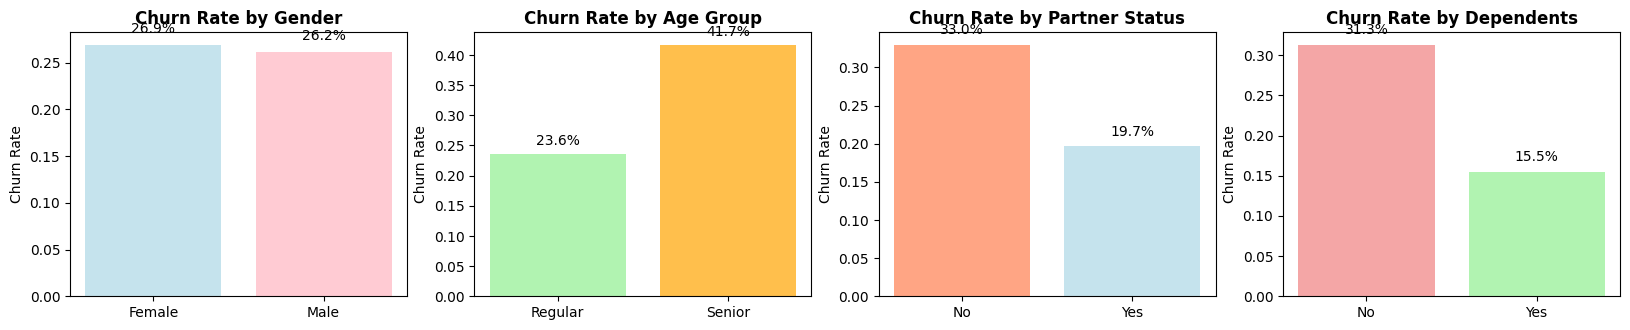

In [25]:
fig = plt.figure(figsize=(20, 24)) ### churn rate on the basis of demographics

# Gender
plt.subplot(6, 4, 1)
gender_churn = df_eda.groupby('gender')['Churn_Binary'].mean()
bars = plt.bar(gender_churn.index, gender_churn.values, alpha=0.7, color=['lightblue', 'lightpink'])
plt.title('Churn Rate by Gender', fontweight='bold')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, gender_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Senior Citizen
plt.subplot(6, 4, 2)
senior_churn = df_eda.groupby('SeniorCitizen')['Churn_Binary'].mean()
senior_labels = ['Regular', 'Senior']
bars = plt.bar(senior_labels, senior_churn.values, alpha=0.7, color=['lightgreen', 'orange'])
plt.title('Churn Rate by Age Group', fontweight='bold')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, senior_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Partner
plt.subplot(6, 4, 3)
partner_churn = df_eda.groupby('Partner')['Churn_Binary'].mean()
bars = plt.bar(partner_churn.index, partner_churn.values, alpha=0.7, color=['coral', 'lightblue'])
plt.title('Churn Rate by Partner Status', fontweight='bold')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, partner_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Dependents
plt.subplot(6, 4, 4)
dependents_churn = df_eda.groupby('Dependents')['Churn_Binary'].mean()
bars = plt.bar(dependents_churn.index, dependents_churn.values, alpha=0.7, color=['lightcoral', 'lightgreen'])
plt.title('Churn Rate by Dependents', fontweight='bold')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, dependents_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

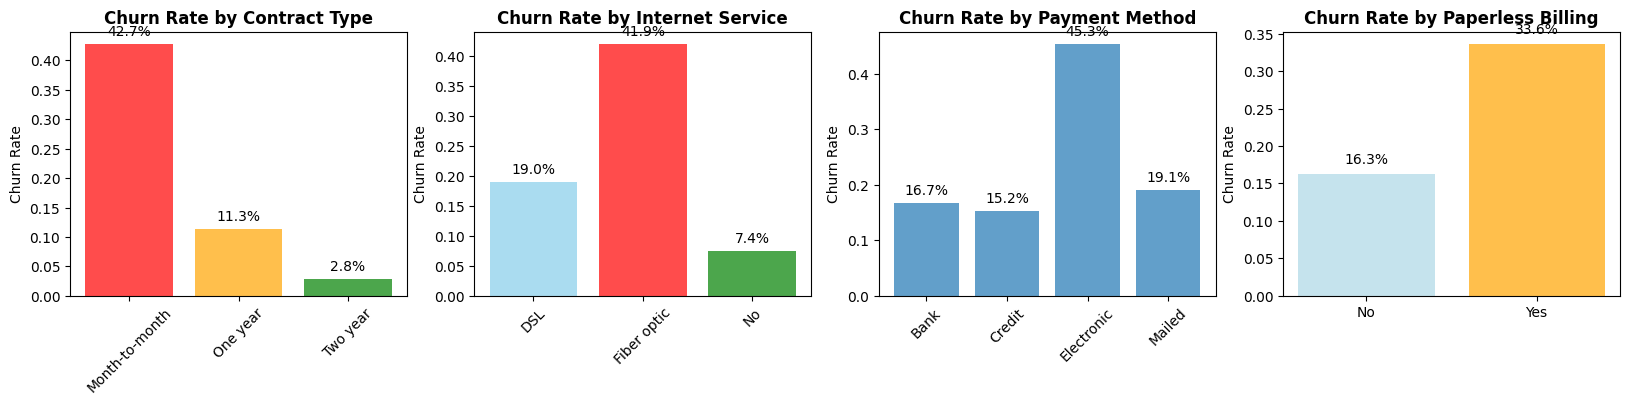

In [27]:
### Churn rate by services provided

fig = plt.figure(figsize=(20, 24))

# Contract Type (Very Important!)
plt.subplot(6, 4, 5)
contract_churn = df_eda.groupby('Contract')['Churn_Binary'].mean()
bars = plt.bar(range(len(contract_churn)), contract_churn.values, alpha=0.7,
               color=['red', 'orange', 'green'])
plt.title('Churn Rate by Contract Type', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(range(len(contract_churn)), contract_churn.index, rotation=45)
for i, (bar, rate) in enumerate(zip(bars, contract_churn.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Internet Service
plt.subplot(6, 4, 6)
internet_churn = df_eda.groupby('InternetService')['Churn_Binary'].mean()
bars = plt.bar(range(len(internet_churn)), internet_churn.values, alpha=0.7,
               color=['skyblue', 'red', 'green'])
plt.title('Churn Rate by Internet Service', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(range(len(internet_churn)), internet_churn.index, rotation=45)
for i, (bar, rate) in enumerate(zip(bars, internet_churn.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Payment Method
plt.subplot(6, 4, 7)
payment_churn = df_eda.groupby('PaymentMethod')['Churn_Binary'].mean()
bars = plt.bar(range(len(payment_churn)), payment_churn.values, alpha=0.7)
plt.title('Churn Rate by Payment Method', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(range(len(payment_churn)), [method.split()[0] for method in payment_churn.index], rotation=45)
for i, (bar, rate) in enumerate(zip(bars, payment_churn.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# Paperless Billing
plt.subplot(6, 4, 8)
paperless_churn = df_eda.groupby('PaperlessBilling')['Churn_Binary'].mean()
bars = plt.bar(paperless_churn.index, paperless_churn.values, alpha=0.7, color=['lightblue', 'orange'])
plt.title('Churn Rate by Paperless Billing', fontweight='bold')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, paperless_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

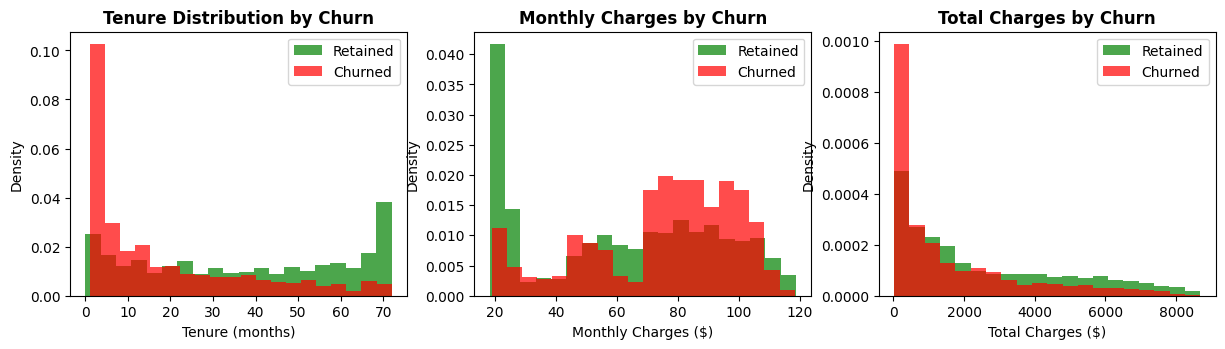

In [28]:
fig = plt.figure(figsize=(20, 24)) ### churn and not churn analysis on the basis of numerical columns

# Tenure Distribution
plt.subplot(6, 4, 9)
churned = df_eda[df_eda['Churn'] == 'Yes']['tenure']
retained = df_eda[df_eda['Churn'] == 'No']['tenure']
plt.hist(retained, bins=20, alpha=0.7, label='Retained', color='green', density=True)
plt.hist(churned, bins=20, alpha=0.7, label='Churned', color='red', density=True)
plt.title('Tenure Distribution by Churn', fontweight='bold')
plt.xlabel('Tenure (months)')
plt.ylabel('Density')
plt.legend()

# Monthly Charges Distribution
plt.subplot(6, 4, 10)
churned_charges = df_eda[df_eda['Churn'] == 'Yes']['MonthlyCharges']
retained_charges = df_eda[df_eda['Churn'] == 'No']['MonthlyCharges']
plt.hist(retained_charges, bins=20, alpha=0.7, label='Retained', color='green', density=True)
plt.hist(churned_charges, bins=20, alpha=0.7, label='Churned', color='red', density=True)
plt.title('Monthly Charges by Churn', fontweight='bold')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.legend()

# Total Charges Distribution
plt.subplot(6, 4, 11)
churned_total = df_eda[df_eda['Churn'] == 'Yes']['TotalCharges']
retained_total = df_eda[df_eda['Churn'] == 'No']['TotalCharges']
plt.hist(retained_total, bins=20, alpha=0.7, label='Retained', color='green', density=True)
plt.hist(churned_total, bins=20, alpha=0.7, label='Churned', color='red', density=True)
plt.title('Total Charges by Churn', fontweight='bold')
plt.xlabel('Total Charges ($)')
plt.ylabel('Density')
plt.legend()

Text(0.5, 1.0, 'Feature Correlation Matrix')

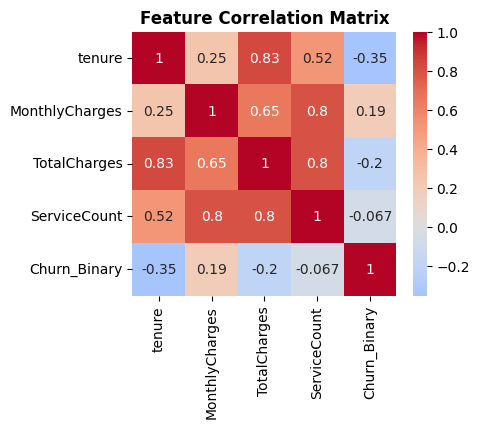

In [30]:
fig = plt.figure(figsize=(20, 24))

service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_eda['ServiceCount'] = 0
for col in service_cols:
    df_eda['ServiceCount'] += (df_eda[col] == 'Yes').astype(int)

plt.subplot(6, 4, 15)
# Create correlation matrix for key numerical variables
corr_data = df_eda[['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 'Churn_Binary']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontweight='bold')

## Feature Engineering

In [31]:
df_features = df_cleaned.copy()

In [33]:
def get_lifecycle_stage(tenure):   ### creating a new column called LifeCycleStage on the basis of your tenure
    if tenure <= 12:
        return 'New'  # 0-12 months
    elif tenure <= 24:
        return 'Growing'  # 12-24 months
    elif tenure <= 48:
        return 'Mature'  # 24-48 months
    else:
        return 'Loyal'  # 48+ months

df_features['LifecycleStage'] = df_features['tenure'].apply(get_lifecycle_stage)

In [34]:
df_features['RevenuePerMonth'] = df_features['TotalCharges'] / (df_features['tenure'] + 1)

### calculating the revenue per month on the basis of total charges divided by your tenure time. And you get to assign a customer value score on the basis of that.

In [35]:
service_features = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_features['ServiceBundleScore'] = 0
for feature in service_features:
    df_features['ServiceBundleScore'] += (df_features[feature] == 'Yes').astype(int)

### calculating survice bundle score on the basis of how many services that customer is availing

In [ ]:
df_features['HighRiskContract'] = (df_features['Contract'] == 'Month-to-month').astype(int)
df_features['FiberOpticUser'] = (df_features['InternetService'] == 'Fiber optic').astype(int)
df_features['PaperlessHighRisk'] = (df_features['PaperlessBilling'] == 'Yes').astype(int)
df_features['SingleCustomer'] = ((df_features['Partner'] == 'No') &
                                 (df_features['Dependents'] == 'No')).astype(int)


### you have now found what are the values of the features that provide a high risk of being churned out.

In [36]:
# Price Sensitivity Indicators
df_features['HighMonthlyCharges'] = (df_features['MonthlyCharges'] >
                                    df_features['MonthlyCharges'].quantile(0.75)).astype(int)

# Interaction Features
df_features['TenureChargesRatio'] = df_features['tenure'] / (df_features['MonthlyCharges'] + 1)
df_features['ChargesPerService'] = df_features['MonthlyCharges'] / (df_features['ServiceBundleScore'] + 1)

# Customer Stability Score
df_features['StabilityScore'] = (
    (df_features['Partner'] == 'Yes').astype(int) +
    (df_features['Dependents'] == 'Yes').astype(int) +
    (df_features['Contract'] != 'Month-to-month').astype(int) +
    (df_features['tenure'] > 24).astype(int)
)

In [37]:
df_features['target'] = (df_features['Churn'] == 'Yes').astype(int)

In [38]:
categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'LifecycleStage'
]

numerical_features = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
    'ServiceBundleScore', 'RevenuePerMonth', 'TenureChargesRatio',
    'ChargesPerService', 'StabilityScore'
]

binary_features = [
    'HighRiskContract', 'FiberOpticUser', 'PaperlessHighRisk',
    'SingleCustomer', 'HighMonthlyCharges'
]

In [39]:
from sklearn.preprocessing import LabelEncoder, StandardScaler ### label encoder is used for categorical var and ss is for num
from sklearn.model_selection import train_test_split

In [40]:
df_encoded = df_features.copy()

In [41]:
label_encoders = {}

for feature in categorical_features:
    if feature in ['InternetService', 'Contract', 'PaymentMethod', 'LifecycleStage']:
        # One-hot encode features with multiple meaningful categories
        dummies = pd.get_dummies(df_encoded[feature], prefix=feature, drop_first=False)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded = df_encoded.drop(feature, axis=1)
    else:
        # Label encode binary-like categorical features
        le = LabelEncoder()
        df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
        label_encoders[feature] = le

In [42]:
columns_to_drop = ['customerID', 'Churn']
feature_columns = [col for col in df_encoded.columns if col not in columns_to_drop + ['target']]

X = df_encoded[feature_columns]
y = df_encoded['target']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

In [44]:
scaler = StandardScaler()
numerical_cols = [col for col in feature_columns if col in numerical_features or
                 any(num_feat in col for num_feat in numerical_features)]

In [45]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numerical_cols:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [46]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'correlation_with_target': [abs(X_train[col].corr(y_train)) for col in X_train.columns]
}).sort_values('correlation_with_target', ascending=False)

In [47]:
print(feature_importance.head(10).to_string(index=False))

                       feature  correlation_with_target
       Contract_Month-to-month                 0.406401
             ChargesPerService                 0.392478
                StabilityScore                 0.366827
                        tenure                 0.345593
            TenureChargesRatio                 0.335601
            LifecycleStage_New                 0.314332
   InternetService_Fiber optic                 0.312656
PaymentMethod_Electronic check                 0.309214
             Contract_Two year                 0.302209
          LifecycleStage_Loyal                 0.256234


In [48]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for imbalanced dataset
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"   ✅ Class weights: {class_weight_dict}")
print(f"   • Class 0 (No Churn): {class_weights[0]:.2f}")
print(f"   • Class 1 (Churn): {class_weights[1]:.2f}")

   ✅ Class weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}
   • Class 0 (No Churn): 0.68
   • Class 1 (Churn): 1.88


In [50]:
device = 'cpu'

In [51]:
X_train_numpy = X_train_scaled.astype(float).values
X_test_numpy = X_test_scaled.astype(float).values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_numpy).to(device)
X_test_tensor = torch.FloatTensor(X_test_numpy).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

In [52]:
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'class_weights': class_weight_dict
}

In [53]:
torch.save(torch.tensor([class_weight_dict[1]], dtype=torch.float), 'class_weight.pt')

## NN Architecture Building

In [54]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import torch.optim as optim

In [55]:
class ChurnPredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
        super(ChurnPredictor, self).__init__()
        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            # Batch normalization
            layers.append(nn.BatchNorm1d(hidden_size))
            # Activation
            layers.append(nn.ReLU()) ### a = max{0, a_i} -> relu
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        # layers.append(nn.Sigmoid())  # Sigmoid will be applied in the loss function (BCEWithLogitsLoss)

        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)

In [56]:
input_size = X_train_tensor.shape[1]
print(f"   ✅ Input size: {input_size} features")

   ✅ Input size: 36 features


In [57]:
model = ChurnPredictor(
    input_size=input_size,
    hidden_sizes=[256, 128, 64],  # Progressive reduction
    dropout_rate=0.2
).to(device)

In [58]:
print(sum(p.numel() for p in model.parameters()))

51585


In [59]:
print(model)

ChurnPredictor(
  (network): Sequential(
    (0): Linear(in_features=36, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [64]:
# Weighted loss for imbalanced dataset
# BCEWithLogitsLoss combines Sigmoid and BCELoss for numerical stability
pos_weight_tensor = torch.tensor([class_weight_dict[1]], dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


# Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) # Adjusted learning rate and weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [65]:
from sklearn.model_selection import train_test_split

X_val_split, X_train_split, y_val_split, y_train_split = train_test_split(
    X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(),
    test_size=0.8,
    random_state=42, stratify=y_train_tensor.cpu().numpy()
)

# Convert back to tensors
X_train_split_tensor = torch.FloatTensor(X_train_split).to(device)
X_val_split_tensor = torch.FloatTensor(X_val_split).to(device)
y_train_split_tensor = torch.FloatTensor(y_train_split).to(device)
y_val_split_tensor = torch.FloatTensor(y_val_split).to(device)

In [66]:
def train_epoch(model, X_train, y_train, optimizer, criterion):
    """Train model for one epoch"""
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    return loss.item()

In [67]:
def validate_epoch(model, X_val, y_val, criterion):
    """Validate model for one epoch"""
    model.eval()
    with torch.no_grad():
        outputs = model(X_val).squeeze()
        loss = criterion(outputs, y_val)

        predictions = torch.sigmoid(outputs)
        predicted_classes = (predictions > 0.5).float()

        accuracy = (predicted_classes == y_val).float().mean()

    return loss.item(), accuracy.item(), predictions.cpu().numpy()

In [68]:
num_epochs = 500
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 25

# Training history
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, X_train_split_tensor, y_train_split_tensor,
                           optimizer, criterion)

    val_loss, val_accuracy, val_predictions = validate_epoch(
        model, X_val_split_tensor, y_val_split_tensor, criterion
    )

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch < 10:
        print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_accuracy:<10.3f} {current_lr:<10.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_churn_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

1      1.2049       0.8739       0.337      0.000100  
2      1.1712       0.8711       0.352      0.000100  
3      1.1710       0.8685       0.375      0.000100  
4      1.1469       0.8654       0.381      0.000100  
5      1.1283       0.8625       0.391      0.000100  
6      1.1154       0.8596       0.393      0.000100  
7      1.1050       0.8567       0.409      0.000100  
8      1.0952       0.8536       0.422      0.000100  
9      1.0719       0.8503       0.426      0.000100  
10     1.0528       0.8466       0.434      0.000100  
11     1.0565       0.8428       0.438      0.000100  
21     0.9779       0.7985       0.535      0.000100  
31     0.9318       0.7830       0.609      0.000100  
41     0.8967       0.7918       0.648      0.000100  
51     0.8777       0.7968       0.665      0.000050  

Early stopping triggered at epoch 56


In [69]:
model.load_state_dict(torch.load('best_churn_model.pth'))

<All keys matched successfully>